<a href="https://colab.research.google.com/github/KelseyNager/GenAI/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GAN Creation
## Kelsey Nager
## CSC 330
The purpose of this assignment is to generate a new image of a bedroom. This is done by building a generator which begins generating images, and the discriminator which differentiates the training images and generated images. These two actors will increasingly become better at generating and discriminating respectively, which will make the generated images more realistic image of bedroom.

I recieved help from Vincent Cammisa on the loading data step of this assignment.

#Downloading Dataset
 https://www.kaggle.com/datasets/jhoward/lsun_bedroom

In [2]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
!pip install patool
!apt-get install p7zip-full  # Make sure you have p7zip-full for better compatibility

import patoolib
import os
import requests

# Specify the path to the archive and the output directory
archive_path = "archive.zip"
output_dir = "dataset"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Download the file using requests in chunks to avoid memory issues
url = "https://www.kaggle.com/api/v1/datasets/download/jhoward/lsun_bedroom"  # Corrected URL

with requests.get(url, stream=True) as r:
    r.raise_for_status()  # Raise an exception for bad responses
    with open(archive_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Dataset downloaded to: {archive_path}")

# Extract the archive using patoolib, trying different methods
try:
    # Try extracting as a zip file first
    patoolib.extract_archive(archive_path, outdir=output_dir, program="unzip")
except patoolib.util.PatoolError as e:
    print(f"Unzip failed: {e}")
    try:
        # If unzip fails, try 7z
        patoolib.extract_archive(archive_path, outdir=output_dir, program="7z")
    except patoolib.util.PatoolError as e:
        print(f"7z extraction failed: {e}")
        print("The downloaded file might be corrupted or not a standard archive format.")

print(f"Archive extracted to: {output_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


INFO patool: Extracting archive.zip ...
INFO:patool:Extracting archive.zip ...
INFO patool: running /usr/bin/unzip -- archive.zip -d dataset
INFO:patool:running /usr/bin/unzip -- archive.zip -d dataset


Dataset downloaded to: archive.zip


INFO patool: ... archive.zip extracted to `dataset'.
INFO:patool:... archive.zip extracted to `dataset'.


Archive extracted to: dataset


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import os
import zipfile


import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from pathlib import Path



##Parameters

In [5]:
#parameters
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 256
Z_DIM = 100

EPOCHS = 50

LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

##Load Data

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory
train_data =  tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 606250 files.


In [7]:
# List the contents of the 'datset' directory
os.listdir('dataset/')

['sample', 'data0']

##Pre-processing, using cache to increase efficiency in training epochs

In [8]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5 ) / 127.5
    return img


train = train_data.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

##Create random subset of 1000

In [9]:
#import utils
!wget https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py


--2024-11-05 02:43:45--  https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-11-05 02:43:45 (32.6 MB/s) - ‘utils.py’ saved [771/771]



In [10]:
from utils import display, sample_batch

In [11]:
def sample_batch(dataset, sample_size=1000):
  """
  Samples a batch of images from the dataset.
  """
  all_images = []
  count = 0
  for images in dataset:
    all_images.append(images)
    count += images.shape[0]
    if count >= sample_size:
      break

  # Concatenate all images into a single tensor
  all_images = tf.concat(all_images, axis=0)

  # Take only the first sample_size images
  return all_images[:sample_size]

train_sample = sample_batch(train, sample_size=1000)

In [12]:
from utils import display

Shape of subset_sample: (1000, 64, 64, 3)
Data type of subset_sample: <dtype: 'float32'>


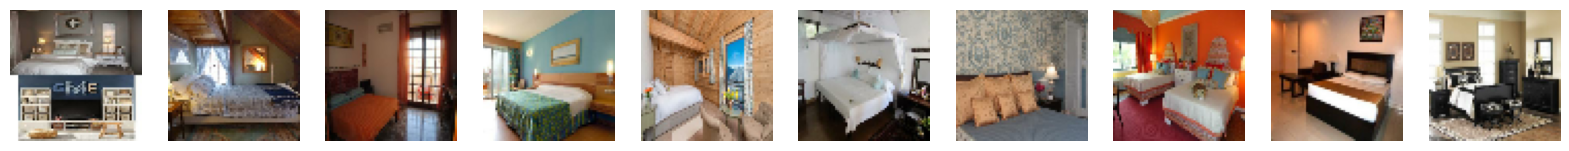

In [13]:
# make sure utils.py is in colab
# https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/utils.py

# --- Debugging and data type checks ---
print("Shape of subset_sample:", train_sample.shape)
print("Data type of subset_sample:", train_sample.dtype)

train_sample_np = train_sample.numpy()

# Display sample images
display(train_sample_np)

##Create Generator and Disciminator Models

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


##Original Generated Image

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


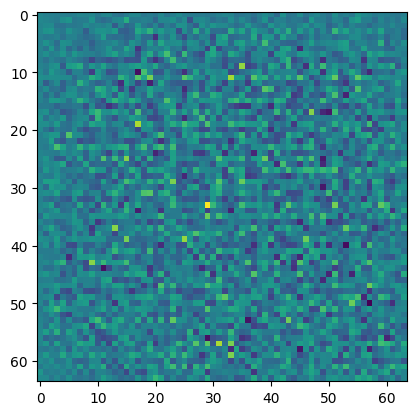

In [15]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00191148]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##Define the loss and optimizers

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##Saving Checkpoints

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
#define training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
@tf.function
def train_step(images):

    images = tf.expand_dims(images, axis=0) #Reshape to add batch dimension

    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [25]:
import time
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


Generating New Images
 Suggestions:

EPOCHS = 50
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16

In [26]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i]+1) / 2.0)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

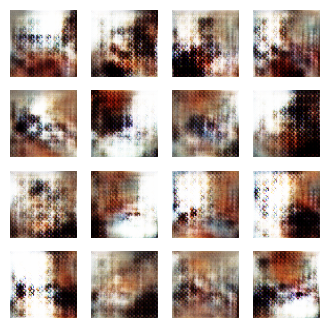

Time for epoch 12 is 498.2582697868347 sec


In [ ]:
train(train_sample, EPOCHS)

At epoch 12 for the sample training set of 1000, it is becoming evident that the generator is becoming increasingly better at creating images representing bedrooms. I noticed that with every epoch, there are similar prominent colors. As epochs develop, there is more color and variety in the images produced. The issue with this GAN is the training time. The training of 50 epochs for this model would take approximately 7 hours. I have not been able to successfully run it for more than 2 hours or return to saved checkpoints. The time to train is inefficient. A couple of potential issues I have tried trouble shooting are: making sure  TPU is properly functioning, making loading and pre-processing data as efficient as possible, and reducing architecture layers where possible.

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
# Display a single image using the epoch number
!pip install Pillow # Install Pillow Library using pip
from PIL import Image # Import the 'Image' module from Pillow library

def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no)) # Use 'Image' from the imported module

In [29]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: '/content/image_at_epoch_0050.png'

In [30]:
!pip install imageio
import imageio # importing the 'imageio' library
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

NameError: name 'filename' is not defined

In [31]:
!pip install tensorflow-docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.2 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: 'dcgan.gif'

#Discussion

The generated images have a greater diversity with every epoch. However I noticed that some of the images much better resemble bedrooms than others of the same epoch. Also, it seems that the images of an epoch have the same prominent colors. I believe that have a larger batch size would create better quality images but would take longer, and have less diversity of images generated. As I mentioned earlier, a different structure may be a more efficient way to develop the GAN. This type of generative model could be useful for generating stock-photo images that could be utilized for textbooks or pamphlets. It could also be useful for generating images of faces for advertisements, to save money and time on real moddels.